In [1]:
import os
import math as m
# theta = batch_size X 1 (degrees)
# points = batch_size X 15 X 3 
# returns : points rotated by thetas
def pose_rotate(points, theta, batch_size):
    theta = theta * m.pi/180.0
    cos_vals = np.cos(theta)
    sin_vals = np.sin(theta)
    row_1 =  np.concatenate((cos_vals,-sin_vals), axis=1)
    row_2 =  np.concatenate((sin_vals,cos_vals), axis=1)
    row_12 = np.stack((row_1,row_2), axis= 1)
    zero_size_row1x2 = np.zeros((batch_size,1,2))
    r1x2xZero = np.concatenate((row_12,zero_size_row1x2), axis=1)
    zero_cols = np.zeros((batch_size,3,1))
    stacker = np.array([0.0, 0.0, 1.0])
    third_cols= np.stack([stacker]*batch_size)
    third_cols =  np.expand_dims(third_cols, 2)
    rotation_matrix = np.concatenate((r1x2xZero, third_cols), axis =2)
    return np.matmul(points, rotation_matrix)

In [2]:
import matplotlib

import matplotlib.pyplot as plt

import tensorflow as tf
from mpl_toolkits.mplot3d import Axes3D
import numpy as np

import math as m

from matplotlib import gridspec

%matplotlib notebook

limb_parents = [0, 0, 1, 2, 3, 1, 5, 6, 1, 0, 9, 10, 11, 0, 13, 14, 15]


def get_figure(figsize=(8,8)):
    fig = plt.figure(frameon=False, figsize=figsize)
    fig.clf()
    return fig


def fig2rgb_array(fig, expand=True):
    fig.canvas.draw()
    buf = fig.canvas.tostring_rgb()
    ncols, nrows = fig.canvas.get_width_height()
    shape = (nrows, ncols, 3) if not expand else (1, nrows, ncols, 3)
    return np.fromstring(buf, dtype=np.uint8).reshape(shape)


def figure_to_summary(fig, iteration_no, train_writer, vis_summary, vis_placeholder):
    image = fig2rgb_array(fig)
    train_writer.add_summary(vis_summary.eval(feed_dict={vis_placeholder: image}), global_step=iteration_no)
    plt.close(fig)


def draw_limbs_3d_plt(joints_3d, ax, limb_parents=limb_parents, z_tilt=True):
    for i in range(joints_3d.shape[0]):
        x_pair = [joints_3d[i, 0], joints_3d[limb_parents[i], 0]]
        y_pair = [joints_3d[i, 1], joints_3d[limb_parents[i], 1]]
        z_pair = [joints_3d[i, 2], joints_3d[limb_parents[i], 2]]
        if z_tilt:
            ax.plot(z_pair, x_pair, y_pair, linewidth=3, antialiased=True)
        else:
            ax.plot(x_pair, y_pair, z_pair, linewidth=3, antialiased=True)
            
def draw_limbs_2d_plt(joints_2d, ax, limb_parents=limb_parents, z_tilt=True):
    for i in range(joints_2d.shape[0]):
        x_pair = [joints_2d[i, 0], joints_2d[limb_parents[i], 0]]
        y_pair = [joints_2d[i, 1], joints_2d[limb_parents[i], 1]]
        
        
        ax.plot(x_pair, y_pair, linewidth=3, antialiased=True)            

def get_ax_2d(joints_3d, fig, az=0, ele=10, subplot='111'):
    x, y, z = subplot
    ax = fig.add_subplot(subplot)

    lim = np.max(np.abs(joints_3d))
#     ax.view_init(azim=az, elev=ele)

    ax.set_xlim(lim, -lim)
    ax.set_ylim(-lim, lim)
    
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    
    return ax            

def get_ax(joints_3d, fig, az=0, ele=10, subplot='111'):
    x, y, z = subplot
    ax = fig.add_subplot(subplot, projection='3d')

    lim = np.max(np.abs(joints_3d))
    ax.view_init(azim=az, elev=ele)

    ax.set_xlim(-lim, lim)
    ax.set_ylim(-lim, lim)
    ax.set_zlim(-lim, lim)
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('z')

    return ax

def do_scatter(pose, ax, z_tilt=False):
  
    lim = np.max(np.abs(pose))

    if z_tilt:
        ax.scatter(pose[:,2], pose[:,0],pose[:,1])
    else:    
        ax.scatter(pose[:,0], pose[:,1],pose[:,2])
    for i in range(pose.shape[0]):
        x,y,z = pose[i]
        if not z_tilt:
            ax.text(x,y,z, str(i))
        else:
            ax.text(z,x,y, str(i))


def get_skeleton_plot(joints_3d, ax, limb_parents=limb_parents, title="", z_tilt=True, proj='3d'):
    if proj == '3d':
        draw_limbs_3d_plt(joints_3d, ax, limb_parents, z_tilt)
    else:
        draw_limbs_2d_plt(joints_3d, ax, limb_parents, z_tilt)
    plt.title(title)


def plot_skeleton(joints_3d, ax, limb_parents=limb_parents, title="", z_tilt=True, proj='3d'):
    get_skeleton_plot(joints_3d, ax, limb_parents, title, z_tilt=z_tilt, proj=proj)


def fig2data(fig):
    fig.canvas.draw()

    # Get the RGBA buffer from the figure
    w, h = fig.canvas.get_width_height()
    buf = np.fromstring(fig.canvas.tostring_argb(), dtype=np.uint8)
    buf.shape = (w, h, 4)

    # canvas.tostring_argb give pixmap in ARGB mode. Roll the ALPHA channel to have it in RGBA mode
    buf = np.roll(buf, 3, axis=2)
    return buf


def plot_skeleton_and_scatter(ske, ax, mono=False, proj='3d'):
    plot_skeleton(ske, ax, z_tilt=mono, proj=proj)
    # do_scatter(ske,ax)

In [35]:
import scipy.io as sio
import os
print('Working Directory', os.getcwd())
mat = sio.loadmat('../../../mads_parsed/parsed_data/poses_3d/HipHop_HipHop1_C0.mat')['pose_3d']
pose = mat[0:1]

('Working Directory', '/data/vcl/sid/pose_generation/rahul_codes/azimuth_based_rule')


In [36]:
rotation_angle = 15

pose_rot = pose_rotate(pose, np.array([[rotation_angle]]), 1)
pose_rot_proj = pose_rot.copy()
pose_rot_proj[:, :, 1] = 0

In [37]:
pose_proj = pose.copy()
pose_proj[:, :, 1] = 0
pose_proj_rot = pose_rotate(pose_proj, np.array([[rotation_angle]]), 1)
# pose_proj_rot[:, :, 1] = 0

<IPython.core.display.Javascript object>


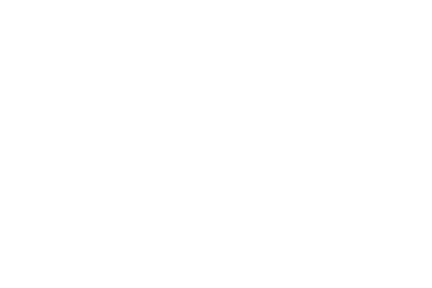

Text(0,0.5,'error')

<IPython.core.display.Javascript object>


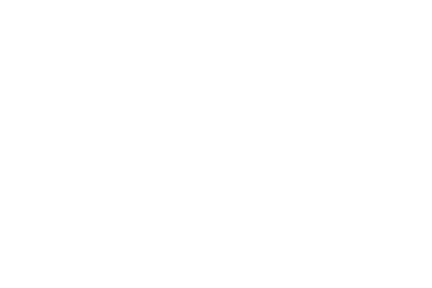

In [38]:
error_list = []
for xx in range(-90, 90):
    pose_rot = pose_rotate(pose, np.array([[xx]]), 1)
    pose_rot_proj = pose_rot.copy()
    pose_rot_proj[:, :, 1] = 0
    
    pose_proj = pose.copy()
    pose_proj[:, :, 1] = 0
    pose_proj_rot = pose_rotate(pose_proj, np.array([[xx]]), 1)
    
    l2_error = np.mean((pose_rot_proj - pose_proj_rot)**2)
    
    error_list.append(l2_error)
    
error_list = np.array(error_list[70:110])
plt.plot(np.arange(-20, 20),  error_list)
plt.xlabel("rotation angle")
plt.ylabel("error")

<IPython.core.display.Javascript object>


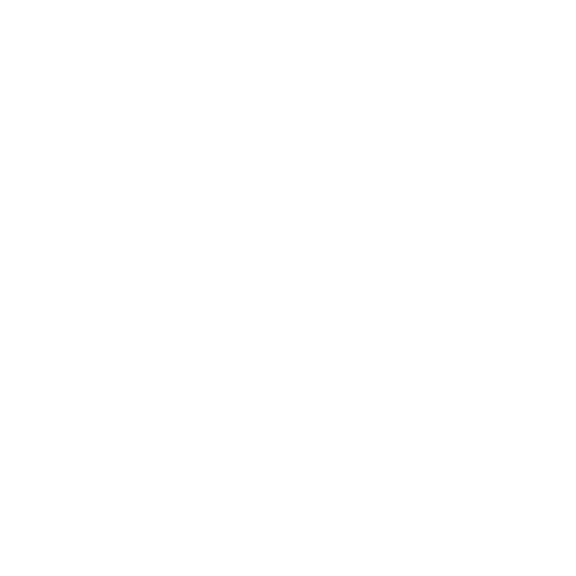

[[[ 0.          0.          0.        ]
  [-0.40143057  0.          4.73196003]
  [ 0.95379763  0.          4.57090738]
  [ 0.91093347  0.          2.05684969]
  [ 1.76481955  0.          0.3320218 ]
  [-1.4011444   0.          4.27080668]
  [-2.13850868  0.          1.68360505]
  [-2.09207932  0.         -0.57412294]
  [ 0.30008231  0.          6.40922503]
  [ 0.95869558  0.          0.07242613]
  [ 2.44217967  0.         -3.64464964]
  [ 2.24879687  0.         -7.08588651]
  [ 3.69850234  0.         -6.78448862]
  [-0.95869558  0.         -0.07242613]
  [-0.65339848  0.         -4.23202447]
  [-0.41982134  0.         -7.48989809]
  [-1.13379464  0.         -7.39605306]]]


<IPython.core.display.Javascript object>


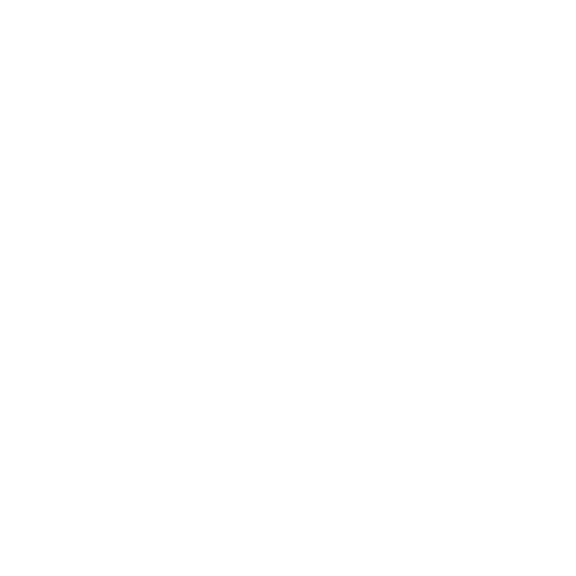

In [39]:
fig = get_figure(figsize=(8,8))

# fig.text(-4,4,"rotation angle")

#First Row 3D
ax = get_ax(pose, fig, az=90, ele=0, subplot='241')
l2_error = np.mean((pose_rot_proj - pose_proj_rot)**2)
l1_error = np.mean(np.abs(pose_rot_proj - pose_proj_rot))
ax.text(-10, 0, 15, "rotation_angle: " + str(rotation_angle) + \
", l2_error: " + "{0:.2f}".format(l2_error) + ", l1_error: " + "{0:.2f}".format(l1_error))
ax.text(7, 0, 8, "pose")
plot_skeleton_and_scatter(pose[0], ax)

ax = get_ax(pose_rot, fig, az=90, ele=0, subplot='242')
ax.text(7, 0, 8, "pose_rot")
plot_skeleton_and_scatter(pose_rot[0], ax)

ax = get_ax(pose_proj, fig, az=90, ele=0, subplot='243')
ax.text(7, 0, 8, "pose_proj")
plot_skeleton_and_scatter(pose_proj[0], ax)

ax = get_ax(pose_proj_rot, fig, az=90, ele=0, subplot='244')
ax.text(9, 0, 8, "pose_proj_rot")
plot_skeleton_and_scatter(pose_proj_rot[0], ax)


#Second Row 2D
ax = get_ax_2d(pose_proj, fig, az=90, ele=0, subplot='245')


plot_skeleton_and_scatter(pose_proj[0][:, [0, 2]], ax, proj='2d')

ax = get_ax_2d(pose_rot_proj, fig, az=90, ele=0, subplot='246')
plot_skeleton_and_scatter(pose_rot_proj[0][:, [0, 2]], ax, proj='2d')

ax = get_ax_2d(pose_proj, fig, az=90, ele=0, subplot='247')
plot_skeleton_and_scatter(pose_proj[0][:, [0, 2]], ax, proj='2d')

ax = get_ax_2d(pose_proj_rot, fig, az=90, ele=0, subplot='248')

plot_skeleton_and_scatter(pose_proj_rot[0][:, [0, 2]], ax, proj='2d')

fig.savefig('./angle.jpg')

print(pose_proj)

# print "l2_error", l2_error
# print "l1_error", l1_error

In [40]:
from image_transformer import ImageTransformer
import matplotlib.pyplot as plt
import cv2
%matplotlib inline
import math
import scipy.io as sio
import numpy as np

def draw_2d_joints(img, pose_2d):
    img_cpy = img.copy()
    for xx in pose_2d:
        x, y = xx.astype(int)
        img_cpy[y:y+5, x:x+5] = [0, 255,0]
    return img_cpy
    


In [43]:
img_path = '../../../mads_parsed/parsed_data/extracted_frames/HipHop_HipHop1_C0/0.png'
img = cv2.imread(img_path)[:,:,::-1]
pose_2d = sio.loadmat('../../../mads_parsed/parsed_data/poses_2d/HipHop_HipHop1_C0.mat')['pose_2d']

In [44]:
rotation_angle = -20
transform_obj = ImageTransformer(img_path, None)
rotated_image = transform_obj.rotate_along_axis(phi=rotation_angle)[:, :, ::-1]
mat = transform_obj.get_M(0,rotation_angle*math.pi/180.0, 0, 0,0,transform_obj.focal)

In [45]:
pose_2d_homo = np.concatenate([pose_2d[0], np.ones([17,1])], 1)
pose_2d_transoformed = np.matmul(mat, pose_2d_homo.T).T
pose_2d_transoformed /= pose_2d_transoformed[:, 2:]
pose_2d_transoformed = pose_2d_transoformed[:, :2]

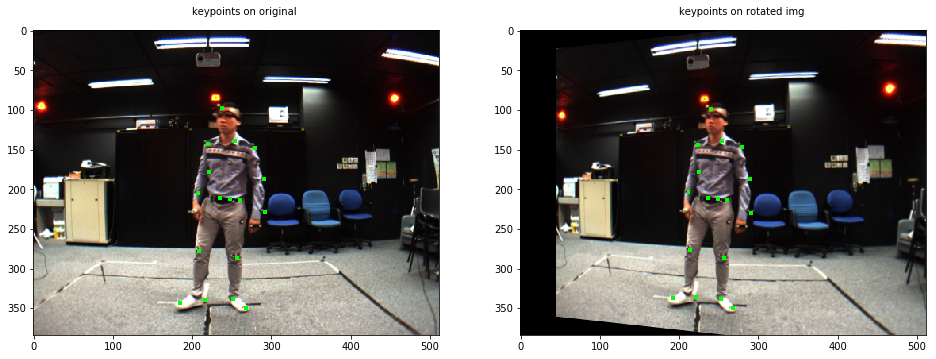

In [46]:
fig = plt.figure(figsize=(16,8))
ax_original = fig.add_subplot('121')
ax_original.text(200, -20, "keypoints on original")
ax_transformed = fig.add_subplot('122')
ax_transformed.text(200, -20, "keypoints on rotated img")

img_orig_keyp_overlayed = draw_2d_joints(img, pose_2d[0])
img_rotated_keyp_overlayed = draw_2d_joints(rotated_image, pose_2d_transoformed)

ax_original.imshow(img_orig_keyp_overlayed)
ax_transformed.imshow(img_rotated_keyp_overlayed)

In [5]:
import cv2
import matplotlib.pyplot as plt
%matplotlib inline
img_path = '../../../../sid/mads_parsed/parsed_data/extracted_frames/HipHop_HipHop1_C0/0.png'
img = cv2.imread(img_path)[:,:,::-1]

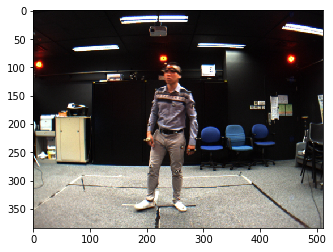

In [6]:
plt.imshow(img)

In [20]:
import numpy as np
img_cpy = img.copy()
img_cpy[:,:, 2] = 255 - img[:,:,2]

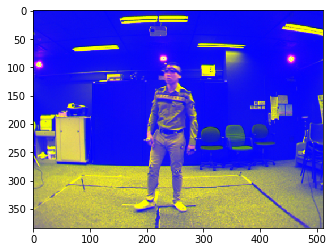

In [21]:
plt.imshow(img_cpy.astype('uint8'))

In [22]:
def adjust_gamma(image, gamma=1.0):

    invGamma = 1.0 / gamma
    table = np.array([((i / 255.0) ** invGamma) * 255
      for i in np.arange(0, 256)]).astype("uint8")

    return cv2.LUT(image, table)

In [23]:
im = adjust_gamma(img, gamma=0.5)

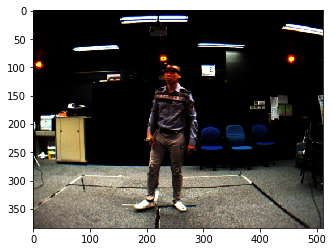

In [24]:
plt.imshow(im)

In [25]:
imgYCC = cv2.cvtColor(img, cv2.COLOR_BGR2YCR_CB)

In [28]:
imgYCC[:,:,2] = 255 - imgYCC[:,:,2]

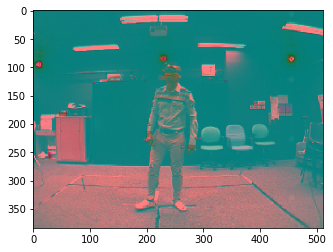

In [29]:
plt.imshow(imgYCC)

In [30]:
imgrgb = cv2.cvtColor(img, cv2.COLOR_YCR_CB2RGB)

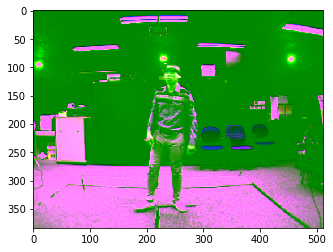

In [31]:
plt.imshow(imgrgb)

In [178]:
import cv2
img_path = '../../../../sid/human36_parsed/parsed_data/center_crops/S1_Discussion_58860488_video_1440_1530_32/crop_params_205_579_499_873_14.png'
img = cv2.imread(img_path)[:,:,::-1]

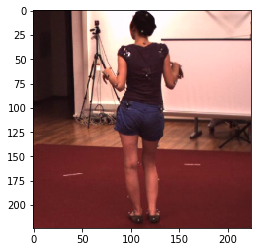

In [179]:
%matplotlib inline
plt.imshow(img)

In [180]:
# import scipy.io as S7_Directions_54138969_video_405_495_9
pose = sio.loadmat('../../../../sid/human36_parsed/parsed_data/simulated_3d_poses/S1_Discussion_58860488_video_1440_1530_32.mat')

In [181]:
p_3d = pose['pose_3d'].reshape([-1, 17, 3])

In [182]:
p_3d.shape

(90, 17, 3)

<IPython.core.display.Javascript object>


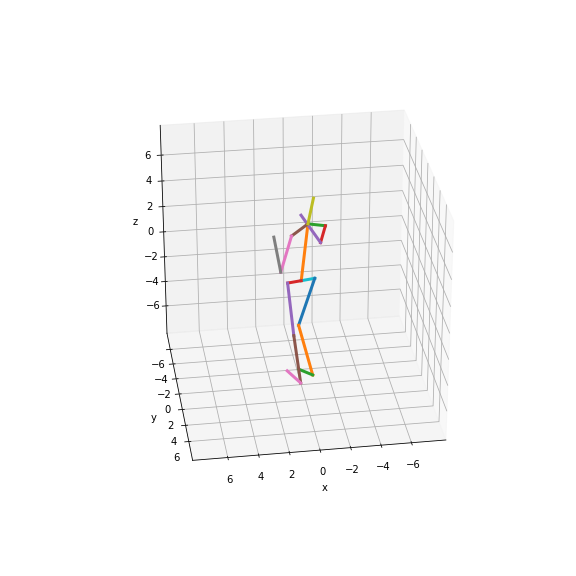

In [183]:
%matplotlib notebook
%matplotlib notebook
%matplotlib notebook
fig = get_figure()
ax = get_ax(p_3d[75], fig, az=90)
plot_skeleton_and_scatter(p_3d[75], ax)